# Sokoban problem (Question 2)

#### The following code block defines the environment, function to perform value iteration using dynamic programming, function for monte carlo first visit and every visit

In [1]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random
from collections import defaultdict
import matplotlib.pyplot as plt

#SOKOBAN ENVIRONMENT 
class SokobanEnv(gym.Env):
    def __init__(self):
        super(SokobanEnv, self).__init__()

        # action space: 0=Up, 1=Down, 2=Left, 3=Right
        self.action_space = spaces.Discrete(4)

        # grid size
        self.grid_size = (7, 6)
        self.observation_space = spaces.Box(low=0, high=4, shape=self.grid_size, dtype=np.int32)

        #  grid layout
        self.initial_grid = np.array([
            [1, 1, 1, 1, 1, 1],
            [1, 0, 4, 1, 1, 1],
            [1, 0, 0, 1, 1, 1],
            [1, 3, 0, 0, 0, 1],
            [1, 0, 0, 2, 0, 1],
            [1, 0, 0, 1, 1, 1],
            [1, 1, 1, 1, 1, 1]
        ])

        self.grid = self.initial_grid.copy()
        self.player_pos = tuple(np.argwhere(self.grid == 4)[0])  # Locate player starting position

        self.images = {
            0: Image.open('space.png'),    # Empty space
            1: Image.open('brick.png'),    # Wall
            2: Image.open('box.png'),      # Box
            3: Image.open('goal.png'),     # Goal
            4: Image.open('man.png')       # Player
        }

    def reset(self):
        # Reset grid 
        self.grid = self.initial_grid.copy()
        self.player_pos = tuple(np.argwhere(self.grid == 4)[0])
        return self.grid
    
    
    def get_initial_grid(self):
        # 
        return self.initial_grid

    def plot_initial_grid(self):
        # Plot initial grid with image overlay
        fig, ax = plt.subplots(figsize=(7, 6))
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                image = self.images[self.initial_grid[i, j]]
                ax.imshow(image, extent=[j, j+1, i, i+1], origin='upper')

        ax.set_xticks(np.arange(0, self.grid_size[1], 1))
        ax.set_yticks(np.arange(0, self.grid_size[0], 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True, which='both', color='black', linewidth=1)
        plt.xlim(0, self.grid_size[1])
        plt.ylim(0, self.grid_size[0])
        plt.gca().invert_yaxis()  # Invert y-axis to match array indexing
        plt.title("Initial Grid")
        plt.show()


    def step(self, action):
        #  action into movement
        new_pos = list(self.player_pos)
        if action == 0:  # Up
            new_pos[0] -= 1
        elif action == 1:  # Down
            new_pos[0] += 1
        elif action == 2:  # Left
            new_pos[1] -= 1
        elif action == 3:  # Right
            new_pos[1] += 1

        # Check if the new position is valid (not a wall)
        if self.grid[new_pos[0], new_pos[1]] == 1:
            return self.grid, -1, False, False, {}

        # Check if the new position contains a box
        if self.grid[new_pos[0], new_pos[1]] == 2:
            # Determine new position of box
            box_new_pos = [new_pos[0] + (new_pos[0] - self.player_pos[0]), new_pos[1] + (new_pos[1] - self.player_pos[1])]
            if self.grid[box_new_pos[0], box_new_pos[1]] in [0, 3]:  # check if box can move?
                # Move box
                self.grid[box_new_pos[0], box_new_pos[1]] = 2
                self.grid[new_pos[0], new_pos[1]] = 4
                self.grid[self.player_pos[0], self.player_pos[1]] = 0
                self.player_pos = tuple(new_pos)

                # Reward of -1 if box is not placed at storage location
                reward = -1
                if self.grid[box_new_pos[0], box_new_pos[1]] == 3:  # If box is on goal
                    reward = 0
            else:
                return self.grid, -1, False, False, {}
        else:
            # Normal movement of the player
            self.grid[new_pos[0], new_pos[1]] = 4
            self.grid[self.player_pos[0], self.player_pos[1]] = 0
            self.player_pos = tuple(new_pos)

            # Reward of -1 if box is not placed at storage location
            reward = -1

        # Check if all boxes are on goals
        done = np.all(np.logical_or(self.grid != 2, self.grid == 3))

        # Check for if box is in irrecoverable position
        if self.is_box_stuck():
            done = True
            reward = -1  # penalty for getting stuck

        return self.grid, reward, done, False, {}

    def is_box_stuck(self):
        # Check if any box is in an unrecoverable position
        
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if self.grid[i, j] == 2:  # If there is a box
                    # Check adjacent positions to see if the box can be moved
                    if self.is_surrounded_by_walls(i, j):
                        return True
        return False

    def is_surrounded_by_walls(self, i, j):
        # Check if the box at (i, j) is surrounded by walls
        return (self.grid[i-1, j] == 1 and
                self.grid[i+1, j] == 1 and
                self.grid[i, j-1] == 1 and
                self.grid[i, j+1] == 1)


    
    def value_iteration(self, theta=1e-4, discount_factor=0.9):
    # Initialize value function and reward matrix
        V = np.zeros(self.grid_size)
        policy = np.full(self.grid_size, None)
        rewards_matrix = np.zeros(self.grid_size)  # Store the cumulative reward for each state

        #  direction map for policy
        direction_map = {
            0: "↑",   # Up
            1: "↓",  # Down
            2: "←",  # Left
            3: "→"   # Right
        }

        while True:
            delta = 0
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    if self.grid[i, j] in [1, 2]:  # Wall or box can't be states
                        continue

                    v = V[i, j]
                    action_values = []
                    rewards = []

                    for action in range(self.action_space.n):
                        new_pos = [i, j]
                        if action == 0:  # Up
                            new_pos[0] -= 1
                        elif action == 1:  # Down
                            new_pos[0] += 1
                        elif action == 2:  # Left
                            new_pos[1] -= 1
                        elif action == 3:  # Right
                            new_pos[1] += 1

                        # Check if the new position is valid
                        if 0 <= new_pos[0] < self.grid_size[0] and 0 <= new_pos[1] < self.grid_size[1]:
                            if self.grid[new_pos[0], new_pos[1]] == 1:  # Wall
                                action_values.append(-float('inf'))
                                rewards.append(-1)  # Negative reward for hitting a wall
                            else:
                                action_value = -1 + discount_factor * V[new_pos[0], new_pos[1]]
                                action_values.append(action_value)
                                rewards.append(-1)  # Reward for moving
                        else:
                            action_values.append(-float('inf'))
                            rewards.append(-1)  # Negative reward for invalid movement

                    V[i, j] = max(action_values)
                    best_action = np.argmax(action_values)
                    policy[i, j] = direction_map[best_action] if action_values else None  # Store direction as arrow
                    rewards_matrix[i, j] = np.mean(rewards)  # Store average reward for each state
                    delta = max(delta, abs(v - V[i, j]))

            if delta < theta:
                break

        # Calculate average reward over all non-wall states
        valid_states = np.sum(self.grid != 1)  # Exclude wall states
        avg_reward = np.sum(rewards_matrix) / valid_states

        print(f"Reward Matrix:\n{rewards_matrix}")
        print(f"Average Reward: \n{avg_reward}")

        return policy

#MC first visit
class MonteCarloFirstVisitSokoban:     
    def __init__(self, env, discount_factor=0.9, max_steps_per_episode=100):
        self.env = env
        self.discount_factor = discount_factor
        self.max_steps_per_episode = max_steps_per_episode  # Maximum steps for each episode to prevent infinite looping between two states
        self.returns_sum = defaultdict(float)  # Dictionary to store the sum of returns
        self.returns_count = defaultdict(int)  # Dictionary to count occurrences of state-action pairs
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q-table for state-action values
        self.policy = {}  # Optimal policy

        # Initialize policy for all possible states in the grid
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                if self.env.initial_grid[i, j] not in [1, 2]:  # Not a wall or box
                    self.policy[(i, j)] = random.choice([0, 1, 2, 3])  # Random initial policy

    def run_episode(self):
        episode = []
        state = self.env.reset()

        # Random starting position (Exploring starts)
        available_positions = np.argwhere((self.env.grid != 1) & (self.env.grid != 2))  # Not walls or boxes
        start_pos = random.choice(available_positions)
        self.env.player_pos = tuple(map(int, start_pos))  

        total_reward = 0  # Track total reward
        steps = 0  # Track number of steps

        done = False

        while not done and steps < self.max_steps_per_episode:
            state = tuple(map(int, self.env.player_pos))  

            # Dynamically initialize the policy for any unvisited state
            if state not in self.policy:
                self.policy[state] = random.choice([0, 1, 2, 3])  # Random initial action

            action = self.policy[state]  # Choose action from policy
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward))  # Append the state, action, reward to the episode
            total_reward += reward  # Accumulate reward
            steps += 1  # Increment step count

        return episode, total_reward, steps

    def update_policy(self, episode):
        G = 0  # Initialize the return
        visited_state_action_pairs = set()  # Track visited state-action pairs

        # Work backward from the last step to the first
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.discount_factor * G + reward  # Update G

            if (state, action) not in visited_state_action_pairs:
                visited_state_action_pairs.add((state, action))

                # Update return sum and count for the first visit of the state-action pair
                self.returns_sum[(state, action)] += G
                self.returns_count[(state, action)] += 1

                # Update Q value
                self.Q[state][action] = self.returns_sum[(state, action)] / self.returns_count[(state, action)]

                # Update the policy to the action with the highest Q value
                self.policy[state] = np.argmax(self.Q[state])

    def train(self, episodes):
        total_rewards = 0  # total rewards across all episodes
        total_steps = 0  # total steps across all episodes

        for i in range(episodes):
            #print(f"Starting episode {i + 1}/{episodes}")  # Print the current episode number
            episode, episode_reward, episode_steps = self.run_episode()
            self.update_policy(episode)

            total_rewards += episode_reward  # Accumulate total rewards
            total_steps += episode_steps  # Accumulate total steps

        # Calculate average reward and average steps per episode
        avg_reward = total_rewards / episodes
        avg_steps = total_steps / episodes

        print(f"\nTraining completed over {episodes} episodes.")
        print(f"Average Reward: {avg_reward:.2f}")
        print(f"Average Steps: {avg_steps:.2f}")

        return self.policy


#MC every visit
class MonteCarloSokoban:  
    def __init__(self, env, discount_factor=0.9, max_steps_per_episode=100):
        self.env = env
        self.discount_factor = discount_factor
        self.max_steps_per_episode = max_steps_per_episode  # Maximum steps for each episode
        self.returns_sum = defaultdict(float)  # Dictionary to store the sum of returns
        self.returns_count = defaultdict(int)  # Dictionary to count occurrences of state-action pairs
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q-table for state-action values
        self.policy = {}  # Optimal policy

        # Initialize policy for all possible states in the grid
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                if self.env.initial_grid[i, j] not in [1, 2]:  # Not a wall or box
                    self.policy[(i, j)] = random.choice([0, 1, 2, 3])  # Random initial policy

    def run_episode(self):
        episode = []
        state = self.env.reset()

        # Random starting position
        available_positions = np.argwhere((self.env.grid != 1) & (self.env.grid != 2))  # Not walls or boxes
        start_pos = random.choice(available_positions)
        self.env.player_pos = tuple(map(int, start_pos))  

        total_reward = 0  # Track total reward of the episode
        steps = 0  # Track steps

        done = False

        while not done and steps < self.max_steps_per_episode:
            state = tuple(map(int, self.env.player_pos))

            
            if state not in self.policy:
                self.policy[state] = random.choice([0, 1, 2, 3])  # Random initial action

            action = self.policy[state]  # Choose action from policy
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward))  # Append the state, action, reward to the episode
            total_reward += reward  # Accumulate reward
            steps += 1  # Increment steps

        return episode, total_reward, steps

    def update_policy(self, episode):
        G = 0  # Initialize return

        # Work backward from the last step to the first
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.discount_factor * G + reward  # Update G

            # Update the return sum and count for every occurrence of the state-action pair
            self.returns_sum[(state, action)] += G
            self.returns_count[(state, action)] += 1

            # Update Q value
            self.Q[state][action] = self.returns_sum[(state, action)] / self.returns_count[(state, action)]

            # Update policy to the action with the highest Q value
            self.policy[state] = np.argmax(self.Q[state])

    def train(self, episodes):
        total_rewards = 0  # Track total rewards across all episodes
        total_steps = 0  # Track total steps across all episodes

        for i in range(episodes):
            #print(f"Starting episode {i + 1}/{episodes}")  # Print the current episode number
            episode, episode_reward, episode_steps = self.run_episode()
            self.update_policy(episode)

            total_rewards += episode_reward  # Accumulate total rewards
            total_steps += episode_steps  # Accumulate total steps

        # Calculate average reward and average steps per episode
        avg_reward = total_rewards / episodes
        avg_steps = total_steps / episodes

        print(f"\nTraining completed over {episodes} episodes.")
        print(f"Average Reward: {avg_reward:.2f}")
        print(f"Average Steps: {avg_steps:.2f}")

        return self.policy


#### This code block defines a function that is used to visualize the policy on the sokoban puzzle

In [2]:
#code to plot grids

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_policy_on_overlayed_grid(grid, policy_matrix, images):
    grid_size = grid.shape
    fig, ax = plt.subplots(figsize=(7, 6))

    # Plot the grid with images
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            image = images[grid[i, j]]
            ax.imshow(image, extent=[j, j+1, i, i+1], origin='upper')

    
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy_matrix[i, j]
            if action is not None:
                dx, dy = 0, 0
                if action == '↑':  # Up
                    dy = -0.5  
                elif action == '↓':  # Down
                    dy = 0.5  
                elif action == '←':  # Left
                    dx = -0.5
                elif action == '→':  # Right
                    dx = 0.5
                
                # Plot the quiver arrows
                ax.quiver(j + 0.5, i + 0.5, dx, dy, scale=1, scale_units='xy', angles='xy', color='red', width=0.005)

    # Set gridlines and limits
    ax.set_xticks(np.arange(0, grid_size[1], 1))
    ax.set_yticks(np.arange(0, grid_size[0], 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, which='both', color='black', linewidth=1)
    plt.xlim(0, grid_size[1])
    plt.ylim(0, grid_size[0])
    plt.gca().invert_yaxis() 
    plt.show()

# Load images for each type of cell
images = {
    0: Image.open('space.png'),    # Empty space
    1: Image.open('brick.png'),    # Wall
    2: Image.open('box.png'),      # Box
    3: Image.open('goal.png'),     # Goal
    4: Image.open('man.png')       # Player
}


#### This is the initial grid

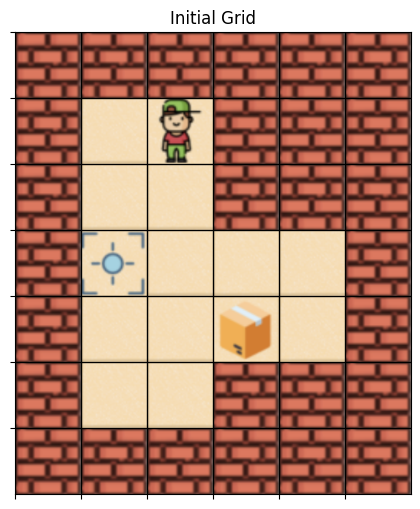

In [3]:
env = SokobanEnv()  #initialize environment
env.reset()
initial_grid = env.initial_grid
env.plot_initial_grid()
env.close()

#### Solving using Value Iteration(dynamic programming)

Reward Matrix:
[[ 0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.]
 [ 0. -1. -1. -1. -1.  0.]
 [ 0. -1. -1.  0. -1.  0.]
 [ 0. -1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
Average Reward: 
-0.9285714285714286

Optimal Policy (arrows indicate direction):
[[None None None None None None]
 [None '↓' '↓' None None None]
 [None '↓' '↓' None None None]
 [None '↓' '↓' '↓' '↓' None]
 [None '→' '→' None '←' None]
 [None '↑' '↑' None None None]
 [None None None None None None]]




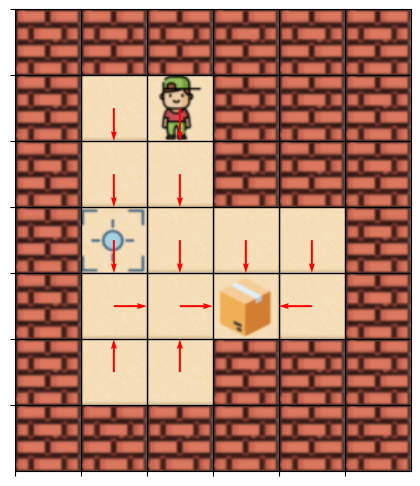

In [4]:
#value iteration
env = SokobanEnv()  #initialize environment
#optimal policy using value iteration
optimal_policy = env.value_iteration()

# Print policy matrix
print("\nOptimal Policy (arrows indicate direction):")
print(optimal_policy)
print("\n")

env.close() # Close environment
plot_policy_on_overlayed_grid(initial_grid, optimal_policy, images)

#### Solving using Monte Carlo First Visit exploring starts


Training completed over 1000 episodes.
Average Reward: -200.00
Average Steps: 200.00

Optimal Policy (Monte Carlo First-Visit Exploring Starts):
[[None None None None None None]
 [None '↑' '↑' None None None]
 [None '←' '→' None None None]
 [None '←' '↓' '↑' '↑' None]
 [None '←' '↑' None '↓' None]
 [None '↓' '↓' None None None]
 [None None None None None None]]


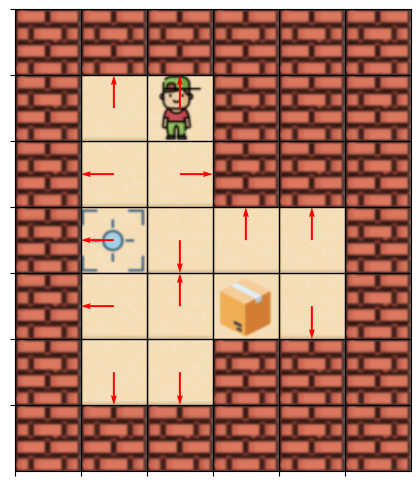

In [5]:
#this code runs monte carlo first visit
env = SokobanEnv()

# Set up Monte Carlo First-Visit exploring-starts agent
mc_agent = MonteCarloFirstVisitSokoban(env, max_steps_per_episode=200) #max steps per episode has been set to prevent infinite loops

# Train agent for a n number of episodes
mc_policy = mc_agent.train(episodes=1000)

# Print optimal policy learnt
print("\nOptimal Policy (Monte Carlo First-Visit Exploring Starts):")
policy_grid = np.full(env.grid_size, None)

# Mapping action numbers to arrows
action_map = {
    0: "↑",   # Up
    1: "↓",  # Down
    2: "←",  # Left
    3: "→"   # Right
}

for i in range(env.grid_size[0]):
    for j in range(env.grid_size[1]):
        if env.initial_grid[i, j] not in [1, 2]:  # Not a wall or box
            policy_grid[i, j] = action_map[mc_policy[(i, j)]]

print(policy_grid)

plot_policy_on_overlayed_grid(initial_grid, policy_grid, images)


#### Solving the problem using Monte Carlo Every Visit exploring starts


Training completed over 1000 episodes.
Average Reward: -100.00
Average Steps: 100.00
Optimal Policy (Monte Carlo Every-Visit Exploring Starts):
[[None None None None None None]
 [None '↑' '↑' None None None]
 [None '←' '→' None None None]
 [None '←' '↓' '↑' '↑' None]
 [None '←' '←' None '↓' None]
 [None '↓' '→' None None None]
 [None None None None None None]]


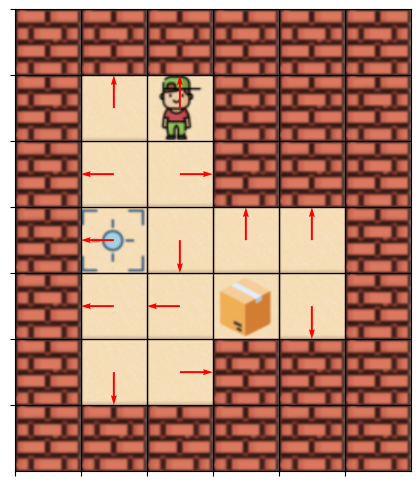

In [6]:
#this code performs monte carlo every visit
env = SokobanEnv()

# Set up Monte Carlo Every-Visit exploring-starts agent
mc_agent = MonteCarloSokoban(env, max_steps_per_episode=100)  # Setting maximum steps per episode to 200

# Train agent 
mc_policy = mc_agent.train(episodes=1000)

# Print the optimal policy
print("Optimal Policy (Monte Carlo Every-Visit Exploring Starts):")
policy_grid = np.full(env.grid_size, None)

# Mapping action numbers to arrows
action_map = {
    0: "↑",   # Up
    1: "↓",  # Down
    2: "←",  # Left
    3: "→"   # Right
}

for i in range(env.grid_size[0]):
    for j in range(env.grid_size[1]):
        if env.initial_grid[i, j] not in [1, 2]: 
            policy_grid[i, j] = action_map[mc_policy[(i, j)]]

print(policy_grid)

plot_policy_on_overlayed_grid(initial_grid, policy_grid, images)
